In [1]:
from exp_framework.Ensemble import Ensemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,

    StudentExpertDelegationMechanism,
)
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
import numpy as np
import matplotlib as mpl
import seaborn as sns

/Users/carterblair/opt/anaconda3/envs/LDE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### - This can be thought of as an online learning learning experiment (just look at the metrics on train), or an experiment where both the train and test streams are non-stationary. 
### - We employ training and voting delegation on the training set, and only voting delegation on the testing set

In [2]:
batch_size = 128
window_size = 350
num_trials = 10
n_voters = 5

In [3]:
data = Data(data_set_name="rotated_mnist")

NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)

student_expert_del_mech = StudentExpertDelegationMechanism(
    batch_size=batch_size, window_size=window_size
)

ensembles = [
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=NOOP_del_mech,
        name="full_ensemble",
        input_dim=28 * 28,
        output_dim=10,
    ),
    StudentExpertEnsemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=student_expert_del_mech,
        name="student_expert_ensemble",
        input_dim=28 * 28,
        output_dim=10,
    ),
]

exp = Experiment(n_trials=num_trials, ensembles=ensembles, data=data, seed=4090)
_ = exp.run()

100%|██████████| 10/10 [24:00<00:00, 144.08s/it]


In [4]:
(
    full_avg_test_accs_per_trial,
    full_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "full_ensemble", num_trials)

full_avg_test_accs, full_std_test_accs = calculate_avg_std_test_accs(
    exp, "full_ensemble", num_trials
)

(
    student_expert_avg_test_accs_per_trial,
    student_expert_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "student_expert_ensemble", num_trials)

student_expert_avg_test_accs, student_expert_std_test_accs = calculate_avg_std_test_accs(
    exp, "student_expert_ensemble", num_trials
)

In [5]:
print(
    "Mean test accs for student expert ensemble:",
    np.mean(student_expert_avg_test_accs_per_trial),
)
print("Mean test accs for full ensemble:          ", np.mean(full_avg_test_accs_per_trial))

Mean test accs for student expert ensemble: 0.8615061540890228
Mean test accs for full ensemble:           0.4550783248051354


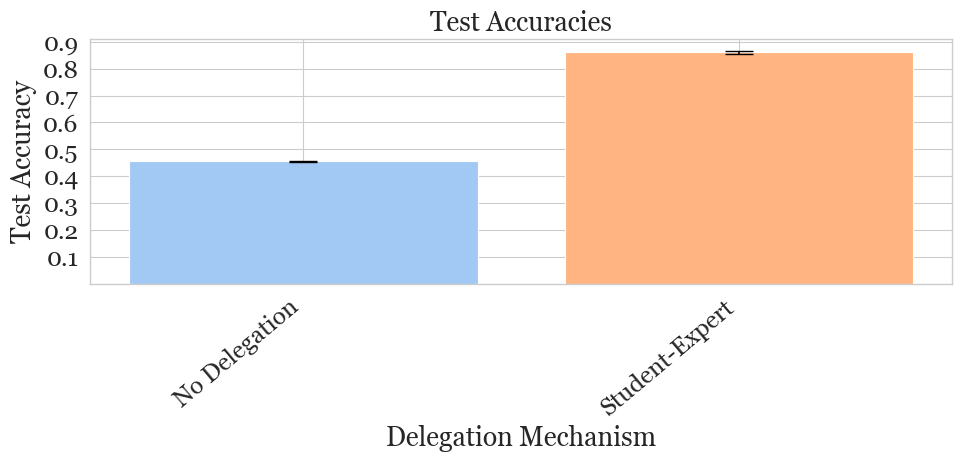

In [6]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Delegation", "Student-Expert"], rotation=40, ha="right")

# set y ticks to be 0.1 apart
ax.set_yticks(np.arange(0.1, 1.1, 0.1))
# Data for bar plot
means = [
    np.mean(full_avg_test_accs),
    np.mean(student_expert_avg_test_accs),
    # np.mean(restricted_max_guru_avg_test_accs),
]
stds = [
    np.std(full_avg_test_accs_per_trial),
    np.std(student_expert_avg_test_accs_per_trial),
    # np.std(restricted_max_guru_avg_test_accs),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [7]:

full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

student_expert_avg_train_accs, student_expert_std_train_accs = calculate_avg_std_train_accs(
    exp, "student_expert_ensemble", num_trials
)

print(
    "Mean train accs for student expert ensemble:",
    np.mean(student_expert_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

Mean train accs for student expert ensemble: 0.9343672230534585
Mean train accs for full ensemble:  0.9395481148728331


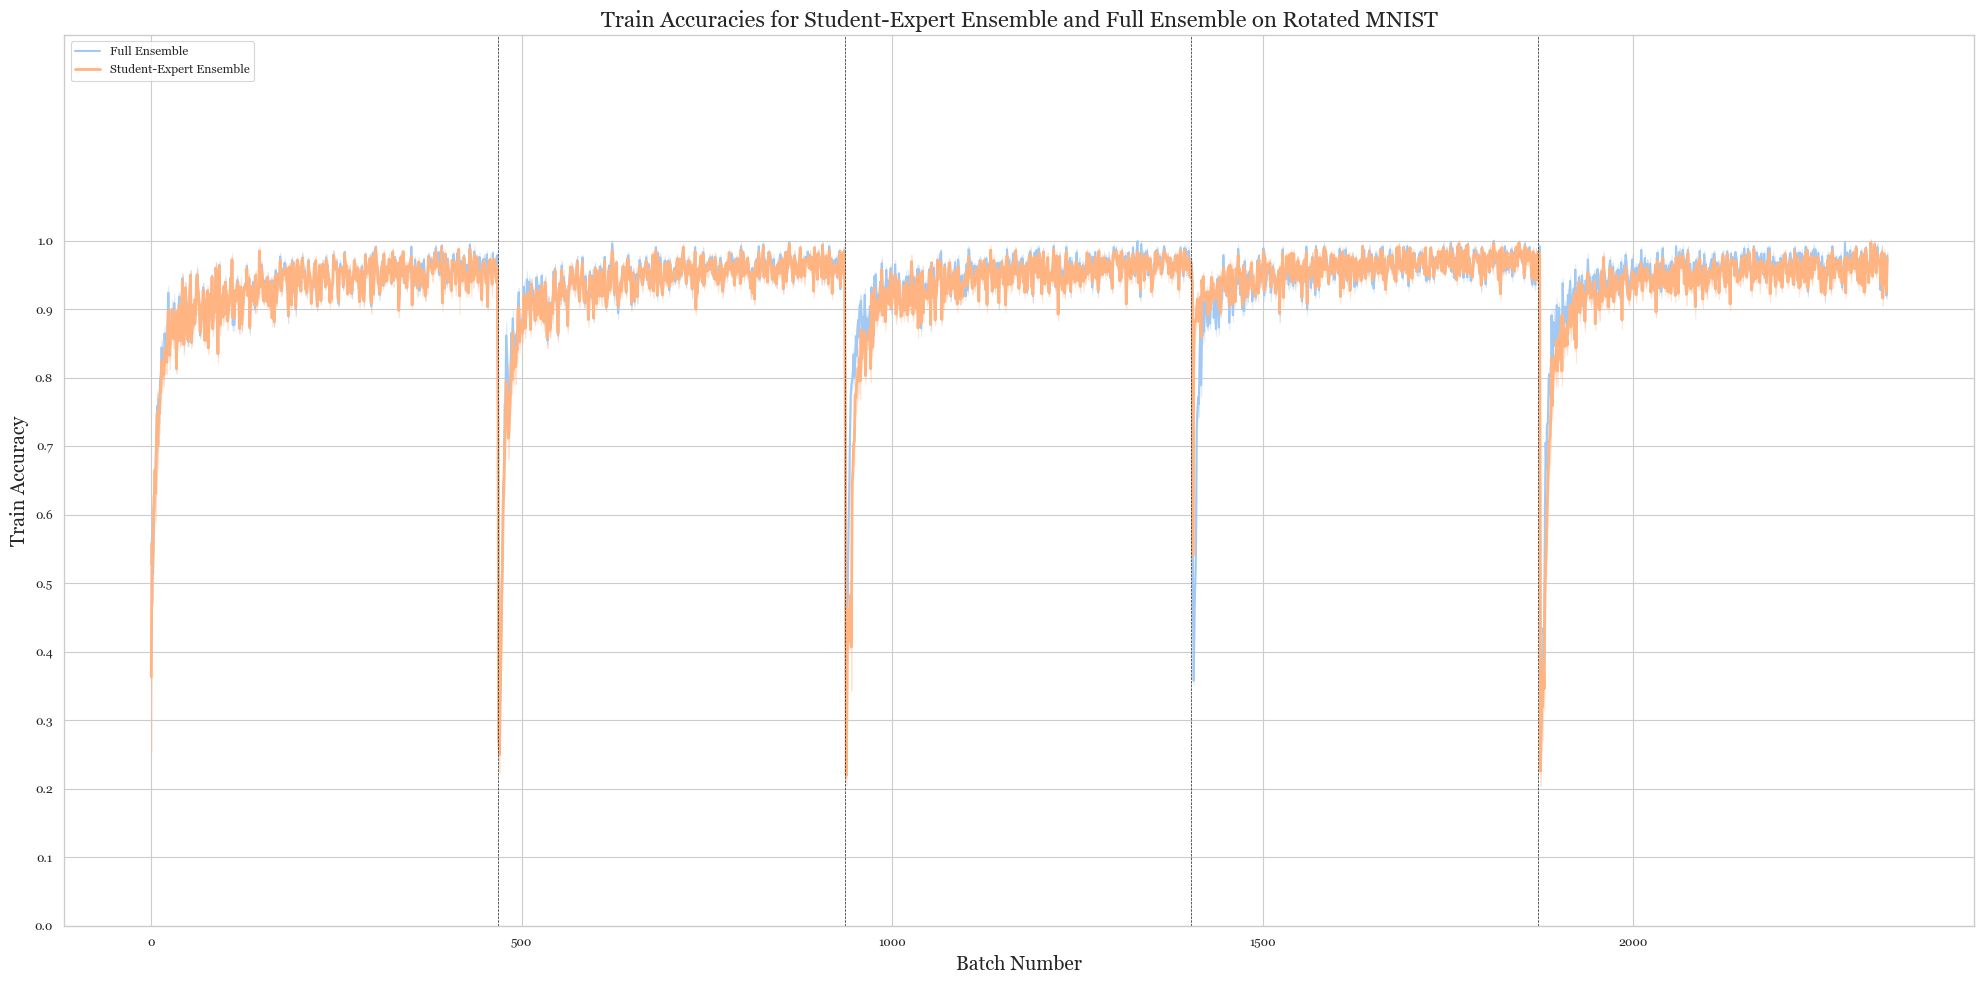

In [18]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(20, 10))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=1.5)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)


ax.plot(
    student_expert_avg_train_accs,
    label="Student-Expert Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(student_expert_avg_train_accs)),
    np.array(student_expert_avg_train_accs) - np.array(student_expert_std_train_accs),
    np.array(student_expert_avg_train_accs) + np.array(student_expert_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)


# plot vertical lines at test splits
for split in exp.train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=0.5)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "Train Accuracies for Student-Expert Ensemble and Full Ensemble on Rotated MNIST"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

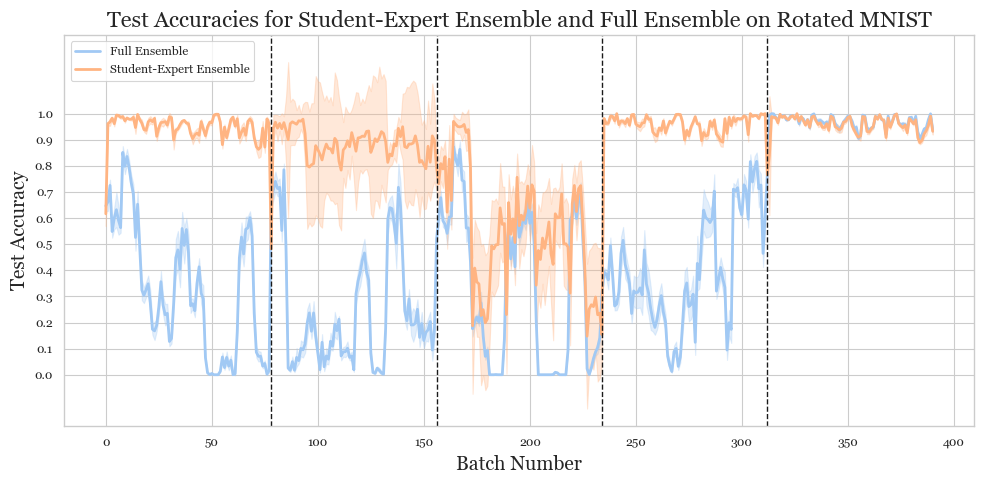

In [19]:
# plot test accuracies
fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(full_avg_test_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_test_accs)),
    np.array(full_avg_test_accs) - np.array(full_std_test_accs),
    np.array(full_avg_test_accs) + np.array(full_std_test_accs),
    color=full_color,
    alpha=0.3,
)

ax.plot(
    student_expert_avg_test_accs,
    label="Student-Expert Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(student_expert_avg_test_accs)),
    np.array(student_expert_avg_test_accs) - np.array(student_expert_std_test_accs),
    np.array(student_expert_avg_test_accs) + np.array(student_expert_std_test_accs),
    color=proba_slope_color,
    alpha=0.3,
)

# plot vertical lines at test splits
for split in exp.test_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Test Accuracy")
ax.set_title(
    "Test Accuracies for Student-Expert Ensemble and Full Ensemble on Rotated MNIST"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [20]:
def visualize_voter_activity(exp, trial_num, n_voters, batch_size, data, ensemble_name = "full_ensemble"):
    """
    Visualize the active streaks and accuracies for each voter.

    :param exp: The experiment object containing necessary data.
    :param trial_num: The trial number to visualize.
    :param n_voters: Number of voters to visualize.
    :param batch_size: Batch size used in the experiment.
    :param data: The data object used in the experiment.
    """
    ps_voters = exp.ensembles[1].voters
    print(exp.ensembles[1].name)
    batch_accs = [v.batch_accuracies for v in ps_voters]
    len_train = len(data.train_data_loader.dataset) / batch_size

    for voter_id in range(n_voters):
        active_streaks = find_active_streaks(exp, voter_id, trial_num, ensemble_name)
        plt.figure(figsize=(10, 5))  # Create a new figure for each voter
        plt.plot(batch_accs[voter_id])
        plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

        # Shade the active batches for this voter
        for streak in active_streaks:
            if streak[0] is not None and streak[1] is not None:
                plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

        # Plot a green vertical line at all train splits
        for split in exp.train_splits[:-1]:
            plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

        # Plot a vertical line at all test splits
        for split in exp.test_splits[:-1]:
            plt.axvline(x=split+len_train, color="pink", linestyle="--", linewidth=2)

        plt.title(f"Voter {voter_id} Activity")
        plt.xlabel("Batches")
        plt.ylabel("Accuracy")
        plt.show()  # Display the plot for each voter

def find_active_streaks(exp, voter_id, trial_num, ensemble_name):
    """
    Find active streaks for a specified voter.

    :param exp: The experiment object containing necessary data.
    :param voter_id: ID of the voter for which to find active streaks.
    :param trial_num: The trial number to analyze.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values[ensemble_name][trial_num][
            "active_voters-train"
        ]
    ):
        if voter_id in av:
            if not voter_active:
                active_streak[0] = i
                voter_active = True
            active_streak[1] = i
        else:
            if voter_active:
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False

    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

student_expert_ensemble


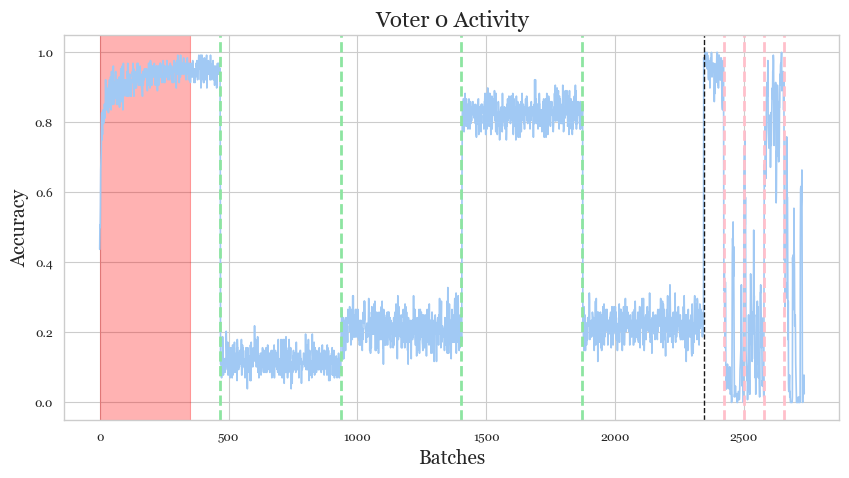

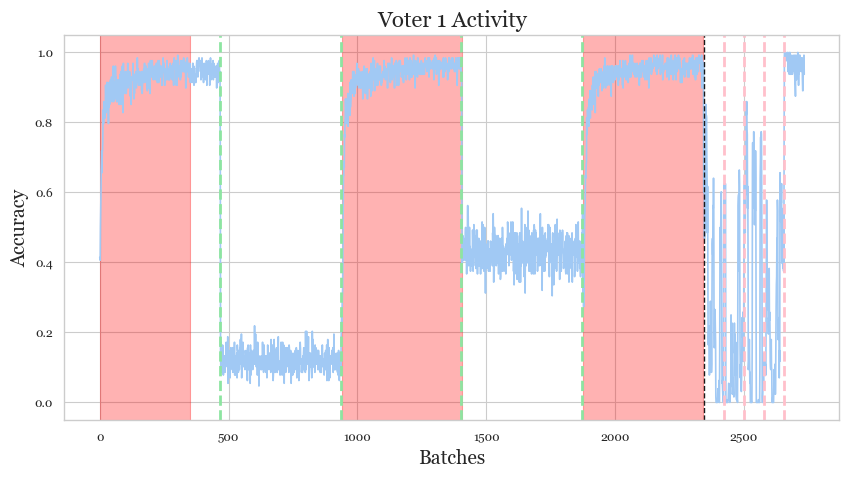

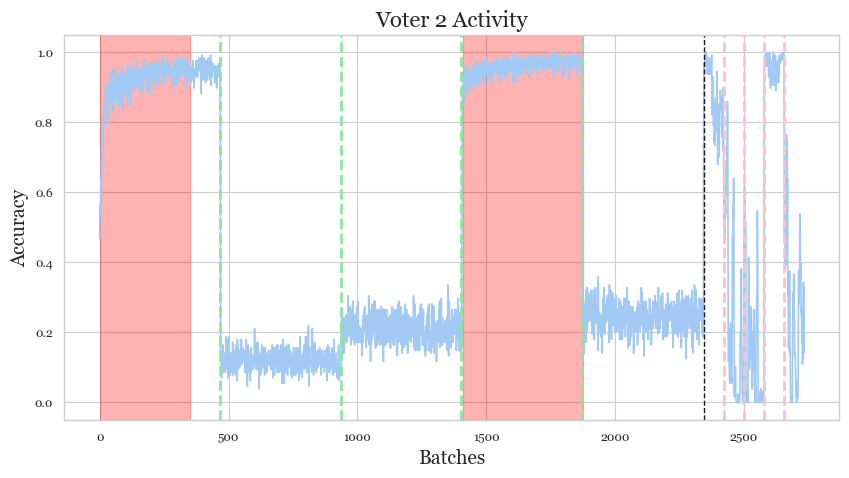

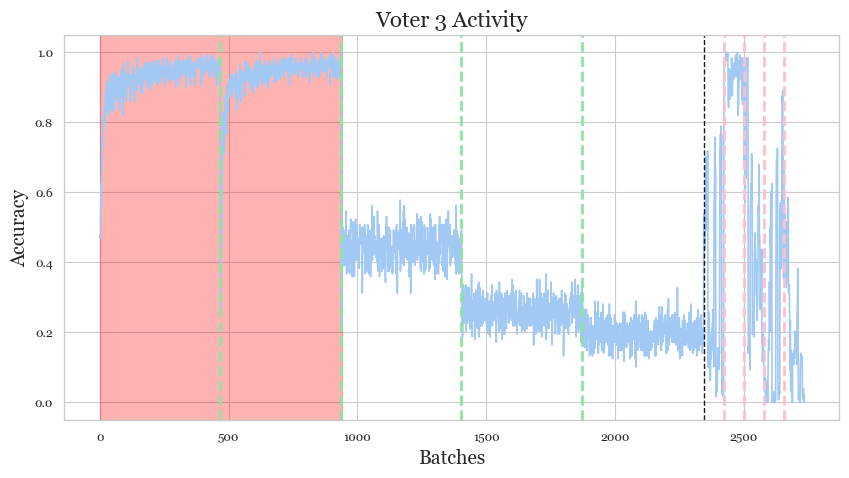

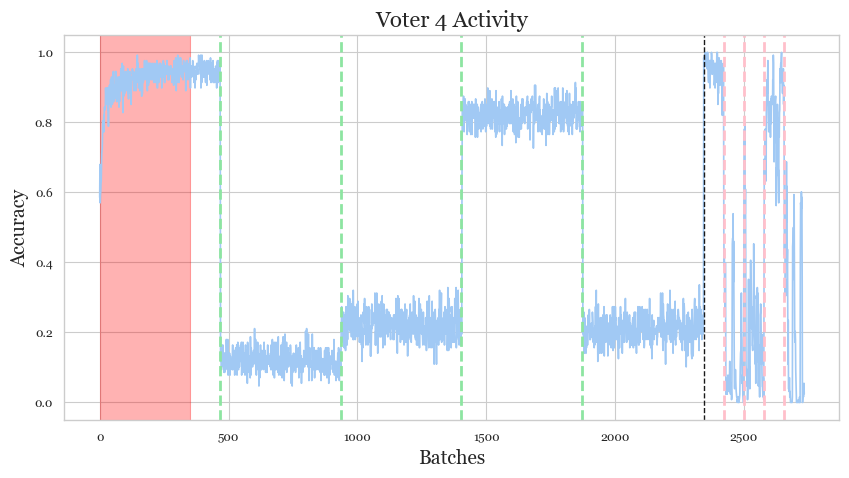

In [21]:
visualize_voter_activity(exp, num_trials - 1, n_voters, batch_size, data, "student_expert_ensemble")